# Speaker Diarization



> This tutorial is available as an IPython notebook at [malaya-speech/example/diarization](https://github.com/huseinzol05/malaya-speech/tree/master/example/diarization).
    


> This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    

> This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).

### What is Speaker Diarization

In one audio sample, we want to know the timestamp for multiple speakers.

In [ ]:
%pip install malaya_speech

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # to stop tensorflow form loading cuda
from malaya_speech import Pipeline
import malaya_speech
import numpy as np
import matplotlib.pyplot as plt

### load Speaker Vector

So to know speakers similarity, we can use speaker vector, just load using `malaya_speech.speaker_vector.deep_model`. Read more about malaya-speech Speaker Vector at https://malaya-speech.readthedocs.io/en/latest/load-speaker-vector.html

We are going to compare `speakernet` and `vggvox-v2`.

#### Downlaod
Download the models:

* [speakernet](https://f000.backblazeb2.com/file/malaya-speech-model/speaker-vector/speakernet/model.pb)
  to:
  `<Home>\Malaya-Speech\speaker-vector`
* [vggvox-v2](https://f000.backblazeb2.com/file/malaya-speech-model/speaker-vector/vggvox-v2/model.pb)
  to:
  `<Home>\Malaya-Speech\vggvox-v2`

In [2]:
model_speakernet = malaya_speech.speaker_vector.deep_model('speakernet',validate=False)
model_vggvox2 = malaya_speech.speaker_vector.deep_model('vggvox-v2',validate=False)

{'version': 'C:\\Users\\ghost\\Malaya-Speech\\speaker-vector\\speakernet\\version', 'model': 'C:\\Users\\ghost\\Malaya-Speech\\speaker-vector\\speakernet\\model.pb'}
{'model': 'speaker-vector/speakernet/model.pb', 'version': 'speaker-vector/speakernet/version'}
{'version': 'C:\\Users\\ghost\\Malaya-Speech\\speaker-vector\\vggvox-v2\\version', 'model': 'C:\\Users\\ghost\\Malaya-Speech\\speaker-vector\\vggvox-v2\\model.pb'}
{'model': 'speaker-vector/vggvox-v2/model.pb', 'version': 'speaker-vector/vggvox-v2/version'}


### Load audio sample

In [3]:
y, sr = malaya_speech.load('../../../audio/conversations/2_speakers.en.wav')
len(y), sr

(719710, 16000)

In [3]:
# just going to take 60 seconds
# y = y[:sr * 60]

This audio extracted from https://www.youtube.com/watch?v=HylaY5e1awo&t=2s

### Load VAD

We need to use VAD module to know which parts of the audio sample are speaker activities, read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

#### Downlaod
Download the VAD:

* [vggvox-v2](https://f000.backblazeb2.com/file/malaya-speech-model/vad/vggvox-v2/model.pb)
  to:
  `<Home>\Malaya-Speech\vad\vggvox-v2`

In [5]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2',validate=False)

{'version': 'C:\\Users\\ghost\\Malaya-Speech\\vad\\vggvox-v2\\version', 'model': 'C:\\Users\\ghost\\Malaya-Speech\\vad\\vggvox-v2\\model.pb'}
{'model': 'vad/vggvox-v2/model.pb', 'version': 'vad/vggvox-v2/version'}


In [6]:
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

In [7]:
p = Pipeline()
pipeline = (
    p.batching(5)
    .foreach_map(vad.predict)
    .flatten()
)
# p.visualize()

In [8]:
%%time

result = p.emit(frames)
result.keys()

C:\Users\ghost\miniconda3\envs\cp37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=480
  n_fft, y.shape[-1]


Wall time: 8.39 s


C:\Users\ghost\miniconda3\envs\cp37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=190
  n_fft, y.shape[-1]


dict_keys(['batching', 'predict', 'flatten'])

In [22]:
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)

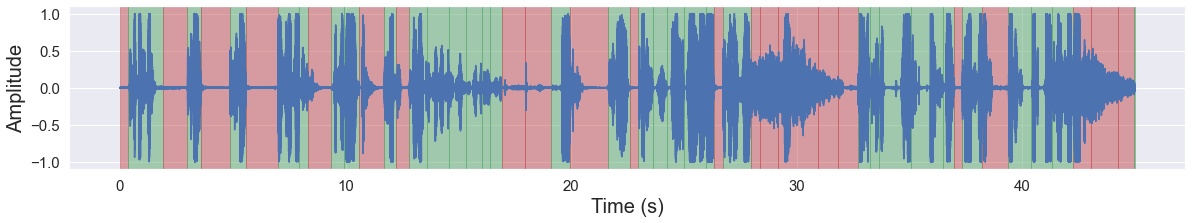

In [23]:
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, figsize = (20, 3))

# fig, ax = plt.subplots(nrows = 1, ncols = 1)
# fig.set_figwidth(15)
# fig.set_figheight(3)
# ax.set_xticks(np.arange(0, 45, 1.0))
# malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, figsize = (15, 3),ax = ax)
# fig.tight_layout()
# plt.show()

### Speaker Similarity

Simplest technique, calculate similarity,

```python
def speaker_similarity(
    vad_results,
    speaker_vector,
    similarity_threshold: float = 0.8,
    norm_function: Callable = None,
    return_embedding: bool = False,
):
    """
    Speaker diarization using L2-Norm similarity.

    Parameters
    ----------
    vad_results: List[Tuple[Frame, label]]
        results from VAD.
    speaker_vector: callable
        speaker vector object.
    speaker_change_results: List[Tuple[FRAME, float]], optional (default=None)
        results from speaker change module, must in float result.
    similarity_threshold: float, optional (default=0.8)
        if current voice activity sample similar at least 80%, we assumed it is from the same speaker.
    norm_function: Callable, optional(default=None)
        normalize function for speaker vectors.
    speaker_change_threshold: float, optional (default=0.5)
        in one voice activity sample can be more than one speaker, split it using this threshold.

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

In [24]:
result_diarization_speakernet = malaya_speech.diarization.speaker_similarity(grouped_vad, model_speakernet)
result_diarization_speakernet[:5]

C:\Users\ghost\miniconda3\envs\cp37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=190
  n_fft, y.shape[-1]


[(<malaya_speech.model.frame.Frame at 0x1752d19f348>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1752d280f08>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x1752d16a688>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1752d18f208>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x1751a2cf6c8>, 'not a speaker')]

In [25]:
result_diarization_vggvox2 = malaya_speech.diarization.speaker_similarity(grouped_vad, model_vggvox2)
result_diarization_vggvox2[:5]

C:\Users\ghost\miniconda3\envs\cp37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=380
  n_fft, y.shape[-1]


[(<malaya_speech.model.frame.Frame at 0x1752d19f348>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1752d280f08>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x1752d16a688>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1752d18f208>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x1751a2cf6c8>, 'not a speaker')]

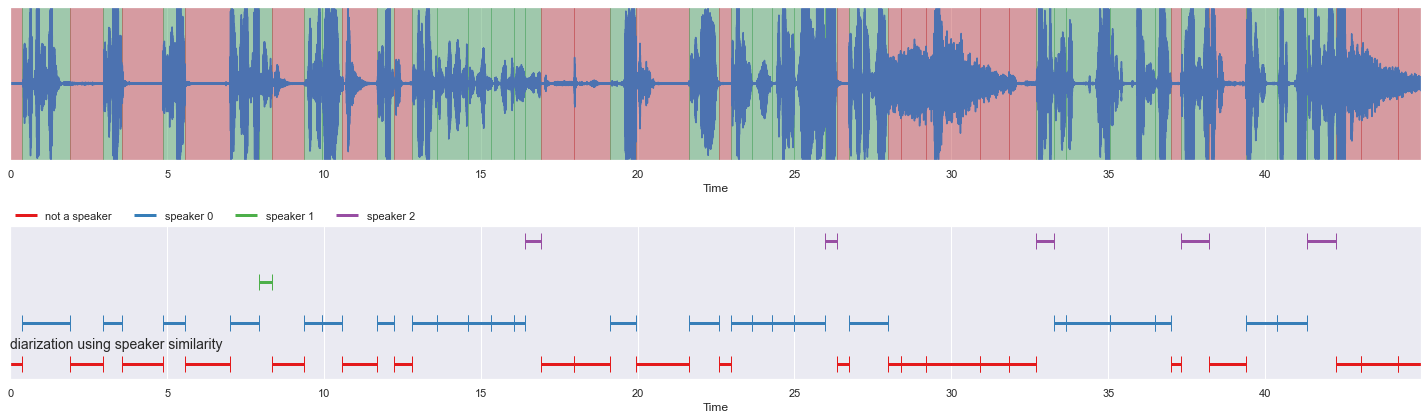

In [26]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)

malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_speakernet, 
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

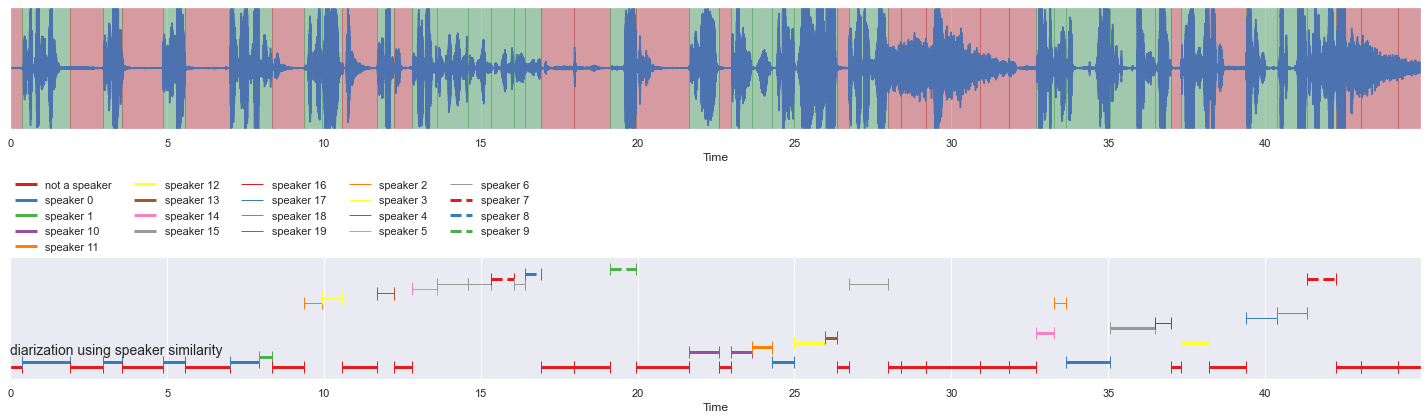

In [27]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_vggvox2, 
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

Problem with speaker similarity, speaker vector models are not really consistent, definition of similarity is ambigious among models, 90% similarity from model A might not be same as model B.

So, to solve this problem, we can use Affinity Propagation, a clustering technique.

### Affinity Propagation

Simply a wrapper with distance norm around sklearn,

```python
def affinity_propagation(
    vad_results,
    speaker_vector,
    norm_function: Callable = l2_normalize,
    log_distance_metric: str = 'cosine',
    damping: float = 0.8,
    preference: float = None,
    return_embedding = False,
):
    """
    Speaker diarization using sklearn Affinity Propagation.

    Parameters
    ----------
    vad_results: List[Tuple[Frame, label]]
        results from VAD.
    speaker_vector: callable
        speaker vector object.
    norm_function: Callable, optional(default=malaya_speech.utils.dist.l2_normalize)
        normalize function for speaker vectors.
    log_distance_metric: str, optional (default='cosine')
        post distance norm in log scale metrics.

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

In [28]:
result_diarization_ap_speakernet = malaya_speech.diarization.affinity_propagation(grouped_vad, model_speakernet)
result_diarization_ap_speakernet[:5]

C:\Users\ghost\miniconda3\envs\cp37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=190
  n_fft, y.shape[-1]


[(<malaya_speech.model.frame.Frame at 0x1752d19f348>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1752d280f08>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x1752d16a688>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1752d18f208>, 'speaker 6'),
 (<malaya_speech.model.frame.Frame at 0x1751a2cf6c8>, 'not a speaker')]

In [29]:
result_diarization_ap_vggvox2 = malaya_speech.diarization.affinity_propagation(grouped_vad, model_vggvox2)
result_diarization_ap_vggvox2[:5]

C:\Users\ghost\miniconda3\envs\cp37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=380
  n_fft, y.shape[-1]


[(<malaya_speech.model.frame.Frame at 0x1752d19f348>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1752d280f08>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x1752d16a688>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1752d18f208>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x1751a2cf6c8>, 'not a speaker')]

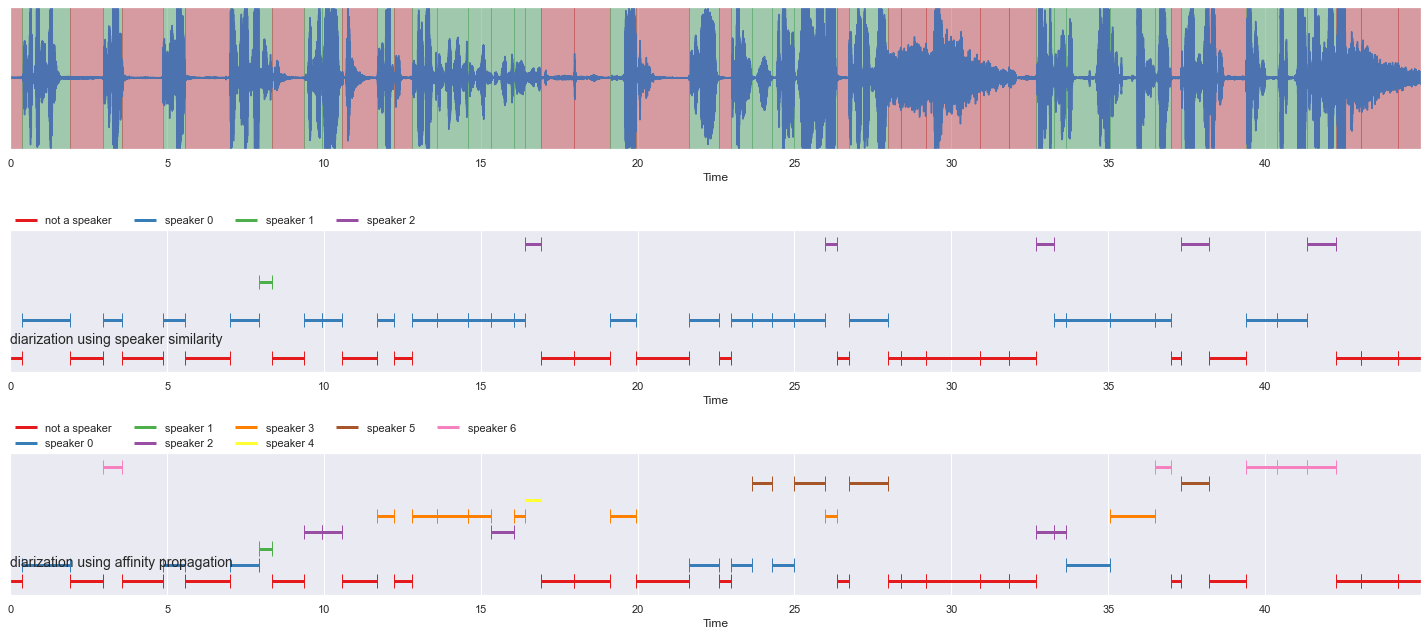

In [30]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_speakernet, 
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_ap_speakernet, 
                                                      'diarization using affinity propagation', ax = ax[2],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

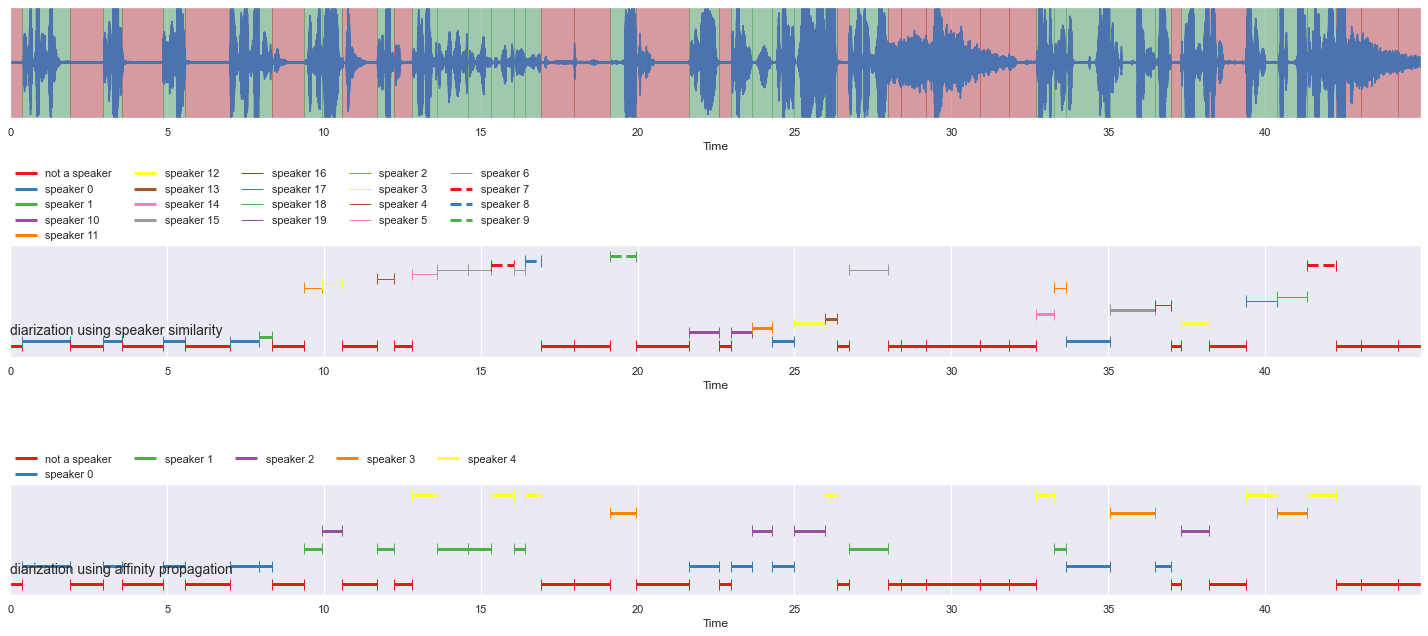

In [31]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_vggvox2, 
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_ap_vggvox2, 
                                                      'diarization using affinity propagation', ax = ax[2],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

### Spectral Clustering

This is a Python re-implementation of the spectral clustering algorithm in the paper [Speaker Diarization with LSTM](https://google.github.io/speaker-id/publications/LstmDiarization/).

So, make sure you already install [spectralcluster](https://pypi.org/project/spectralcluster/),

```bash
pip install spectralcluster
```

```python
def spectral_cluster(
    vad_results,
    speaker_vector,
    min_clusters: int = None,
    max_clusters: int = None,
    p_percentile: float = 0.95,
    gaussian_blur_sigma = 1.0,
    norm_function: Callable = l2_normalize,
    log_distance_metric: str = None,
    return_embedding = False,
    **kwargs,
):
    """
    Speaker diarization using SpectralCluster, https://github.com/wq2012/SpectralCluster

    Parameters
    ----------
    vad_results: List[Tuple[Frame, label]]
        results from VAD.
    speaker_vector: callable
        speaker vector object.
    min_clusters: int, optional (default=None)
        minimal number of clusters allowed (only effective if not None).
    max_clusters: int, optional (default=None)
        maximal number of clusters allowed (only effective if not None).
        can be used together with min_clusters to fix the number of clusters.
    gaussian_blur_sigma: float, optional (default=1.0)
        sigma value of the Gaussian blur operation.
    p_percentile: float, optional (default=0.95)
        the p-percentile for the row wise thresholding.
    norm_function: Callable, optional(default=malaya_speech.utils.dist.l2_normalize)
        normalize function for speaker vectors.
    log_distance_metric: str, optional (default=None)
        post distance norm in log scale metrics.

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

In [ ]:
!pip install spectralcluster

In [32]:
result_diarization_sc_speakernet = malaya_speech.diarization.spectral_cluster(grouped_vad, model_speakernet,
                                                                             min_clusters = 2,
                                                                             max_clusters = 3)
result_diarization_sc_speakernet[:5]

C:\Users\ghost\miniconda3\envs\cp37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=190
  n_fft, y.shape[-1]


[(<malaya_speech.model.frame.Frame at 0x1752d19f348>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1752d280f08>, 'speaker 1'),
 (<malaya_speech.model.frame.Frame at 0x1752d16a688>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1752d18f208>, 'speaker 1'),
 (<malaya_speech.model.frame.Frame at 0x1751a2cf6c8>, 'not a speaker')]

In [33]:
result_diarization_sc_vggvox2 = malaya_speech.diarization.spectral_cluster(grouped_vad, model_vggvox2,
                                                                          min_clusters = 2,
                                                                          max_clusters = 3)
result_diarization_sc_vggvox2[:5]

C:\Users\ghost\miniconda3\envs\cp37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=380
  n_fft, y.shape[-1]


[(<malaya_speech.model.frame.Frame at 0x1752d19f348>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1752d280f08>, 'speaker 1'),
 (<malaya_speech.model.frame.Frame at 0x1752d16a688>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1752d18f208>, 'speaker 1'),
 (<malaya_speech.model.frame.Frame at 0x1751a2cf6c8>, 'not a speaker')]

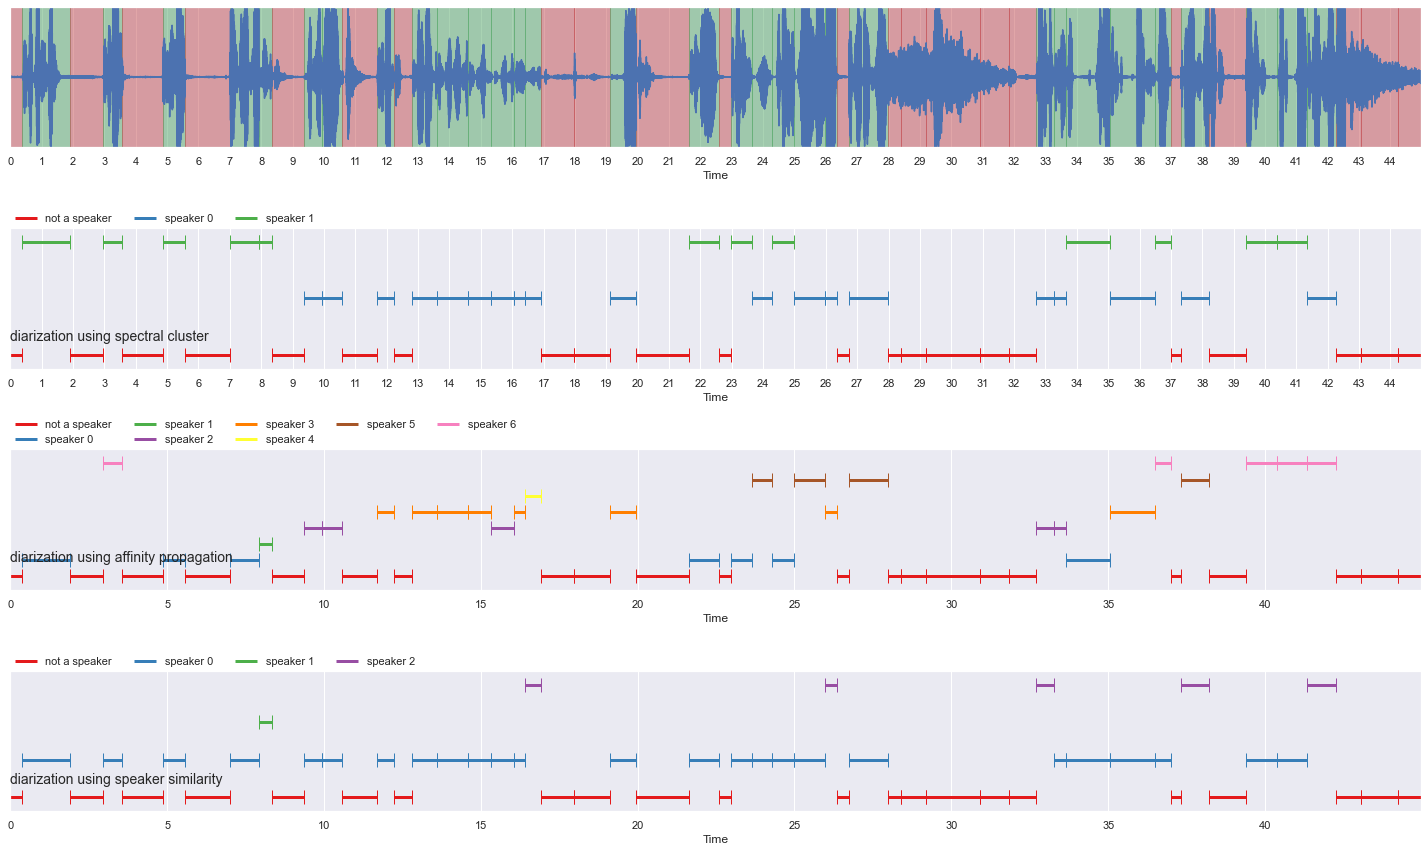

In [36]:
nrows = 4
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
ax[0].set_xticks(np.arange(0, 45, 1.0))
ax[1].set_xticks(np.arange(0, 45, 1.0))

malaya_speech.extra.visualization.plot_classification(result_diarization_speakernet, 
                                                      'diarization using speaker similarity', ax = ax[3],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_ap_speakernet, 
                                                      'diarization using affinity propagation', ax = ax[2],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_sc_speakernet, 
                                                      'diarization using spectral cluster', ax = ax[1],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

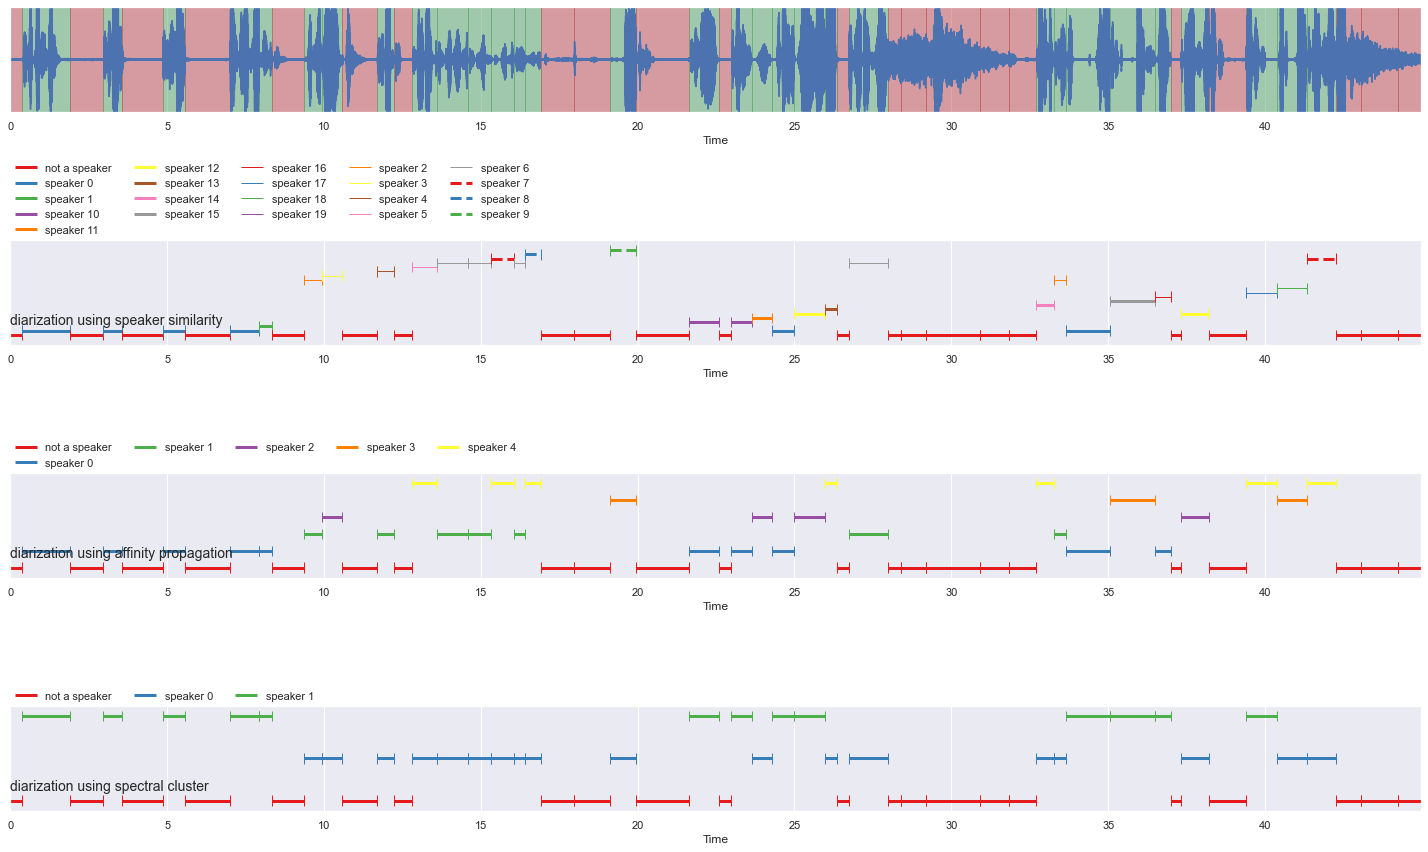

In [37]:
nrows = 4
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_vggvox2, 
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_ap_vggvox2, 
                                                      'diarization using affinity propagation', ax = ax[2],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_sc_vggvox2, 
                                                      'diarization using spectral cluster', ax = ax[3],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

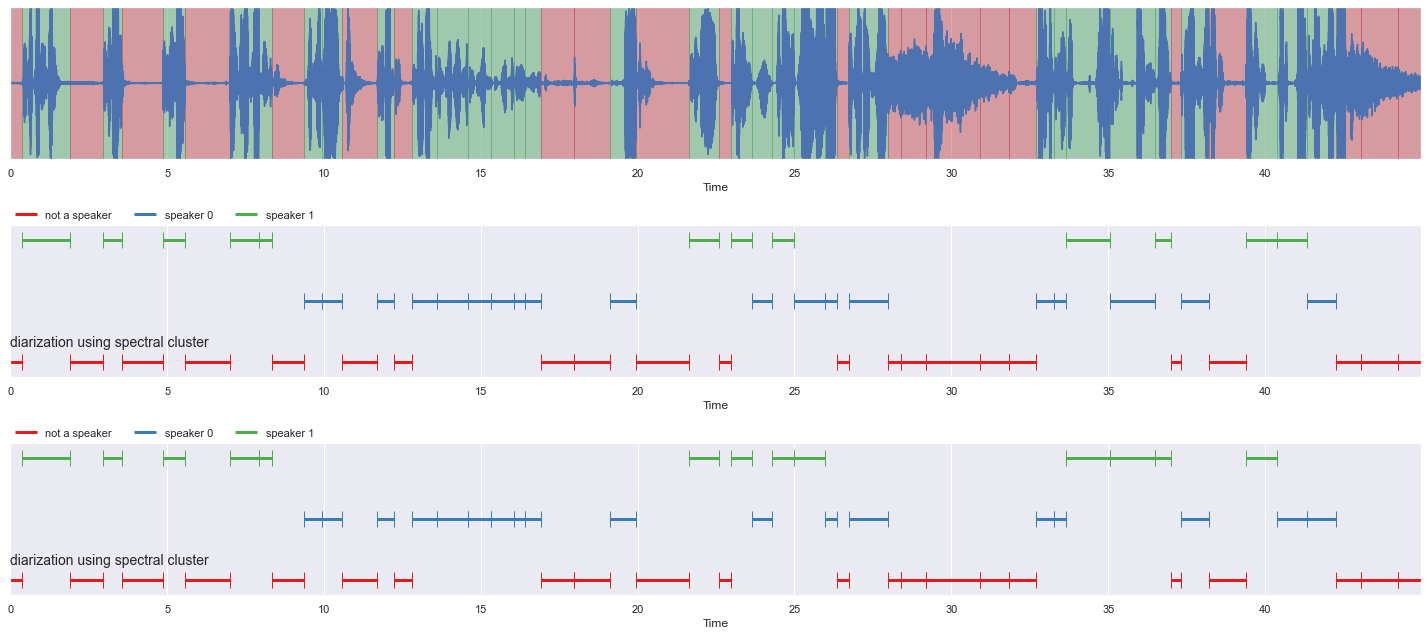

In [40]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_sc_speakernet, 
                                                      'diarization using spectral cluster', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_sc_vggvox2, 
                                                      'diarization using spectral cluster', ax = ax[2],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

### Static N speakers using sklearn clustering

Let say you already know N speakers in the audio sample and want to use Kmean algorithm for that.

```python
def n_clustering(
    vad_results,
    speaker_vector,
    model,
    norm_function: Callable = l2_normalize,
    return_embedding=False,
):
    """
    Speaker diarization using any clustering model.

    Parameters
    ----------
    vad_results: List[Tuple[Frame, label]]
        results from VAD.
    speaker_vector: callable
        speaker vector object.
    model: callable
        Prefer any sklearn unsupervised clustering model. 
        Required `fit_predict` or `apply` method.
    norm_function: Callable, optional(default=malaya_speech.utils.dist.l2_normalize)
        normalize function for speaker vectors.
    log_distance_metric: str, optional (default='cosine')
        post distance norm in log scale metrics.

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

In [41]:
from sklearn.cluster import KMeans, SpectralClustering

n_speakers = 2
kmeans = KMeans(n_clusters = n_speakers)
result_diarization_kmeans_speakernet = malaya_speech.diarization.n_clustering(grouped_vad, model_speakernet,
                                                                          model = kmeans,
                                                                          norm_function = lambda x: x)
result_diarization_kmeans_speakernet[:5]

C:\Users\ghost\miniconda3\envs\cp37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=190
  n_fft, y.shape[-1]


[(<malaya_speech.model.frame.Frame at 0x1752d19f348>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1752d280f08>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x1752d16a688>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1752d18f208>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x1751a2cf6c8>, 'not a speaker')]

In [42]:
spectralclustering = SpectralClustering(n_clusters = n_speakers)
result_diarization_spectralclustering_speakernet = malaya_speech.diarization.n_clustering(grouped_vad, model_speakernet,
                                                                          model = spectralclustering,
                                                                          norm_function = lambda x: x)
result_diarization_spectralclustering_speakernet[:5]

C:\Users\ghost\miniconda3\envs\cp37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=190
  n_fft, y.shape[-1]


[(<malaya_speech.model.frame.Frame at 0x1752d19f348>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1752d280f08>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x1752d16a688>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1752d18f208>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x1751a2cf6c8>, 'not a speaker')]

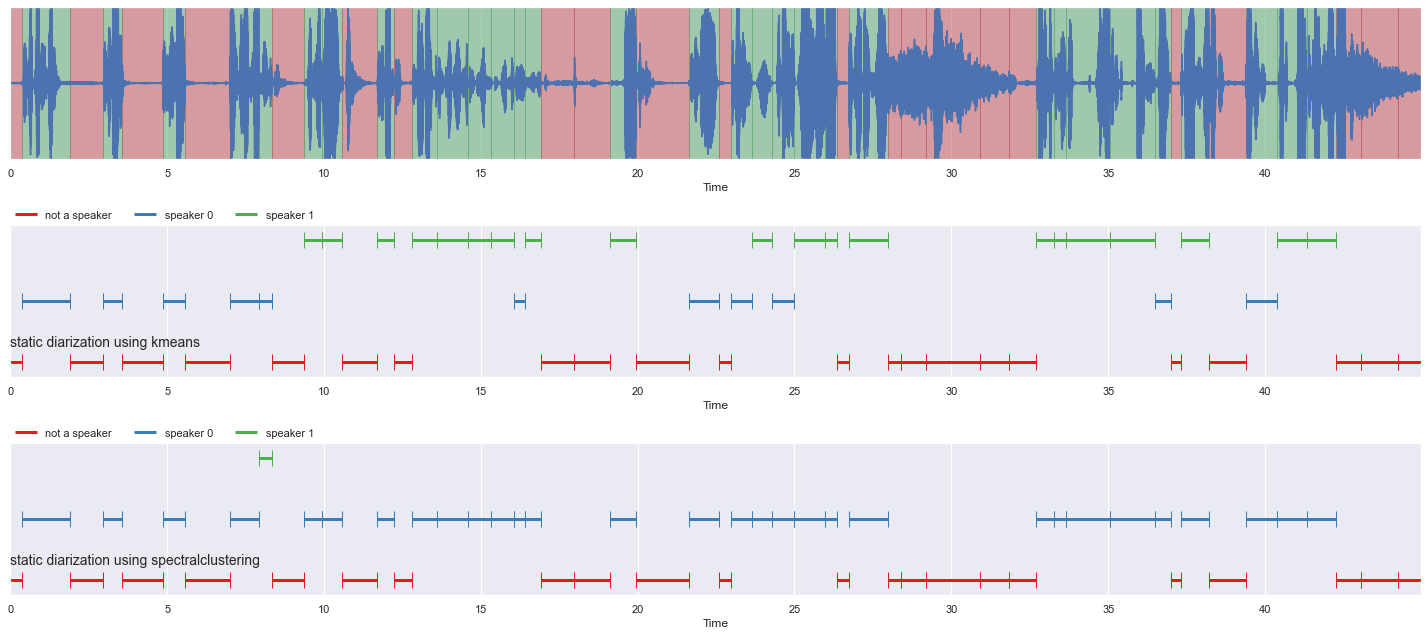

In [43]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_kmeans_speakernet, 
                                                      'static diarization using kmeans', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_spectralclustering_speakernet, 
                                                      'static diarization using spectralclustering', ax = ax[2],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

### Use speaker change detection

Speaker change detection is an important part of speaker diarization systems. It aims at finding the boundaries between speech turns of two different speakers. Read more about Speaker Change at https://malaya-speech.readthedocs.io/en/latest/load-speaker-change.html

#### Downlaod
Download Speaker change detection model:

* [speakernet](https://f000.backblazeb2.com/file/malaya-speech-model/speaker-change/speakernet/model.pb)
  to:
  `<Home>\Malaya-Speech\speaker-vector`

In [46]:
speakernet = malaya_speech.speaker_change.deep_model('speakernet',validate=False)
frames_speaker_change = list(malaya_speech.utils.generator.frames(y, 500, sr))
probs_speakernet = [(frame, speakernet.predict_proba([frame])[0, 1]) for frame in frames_speaker_change]

{'version': 'C:\\Users\\ghost\\Malaya-Speech\\speaker-change\\speakernet\\version', 'model': 'C:\\Users\\ghost\\Malaya-Speech\\speaker-change\\speakernet\\model.pb'}
{'model': 'speaker-change/speakernet/model.pb', 'version': 'speaker-change/speakernet/version'}


In [47]:
nested_grouped_vad = malaya_speech.utils.group.group_frames(grouped_vad)
splitted_speakernet = malaya_speech.speaker_change.split_activities(nested_grouped_vad, probs_speakernet)

In [48]:
result_diarization_sc_splitted_speakernet = malaya_speech.diarization.spectral_cluster(splitted_speakernet, 
                                                                                       model_speakernet,
                                                                                       min_clusters = 2,
                                                                                       max_clusters = 3)
result_diarization_sc_splitted_speakernet[:5]

C:\Users\ghost\miniconda3\envs\cp37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=190
  n_fft, y.shape[-1]


[(<malaya_speech.model.frame.Frame at 0x1752142b2c8>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1752ba87b48>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x1752ba87b88>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x1752142bc08>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x1752142bd08>, 'not a speaker')]

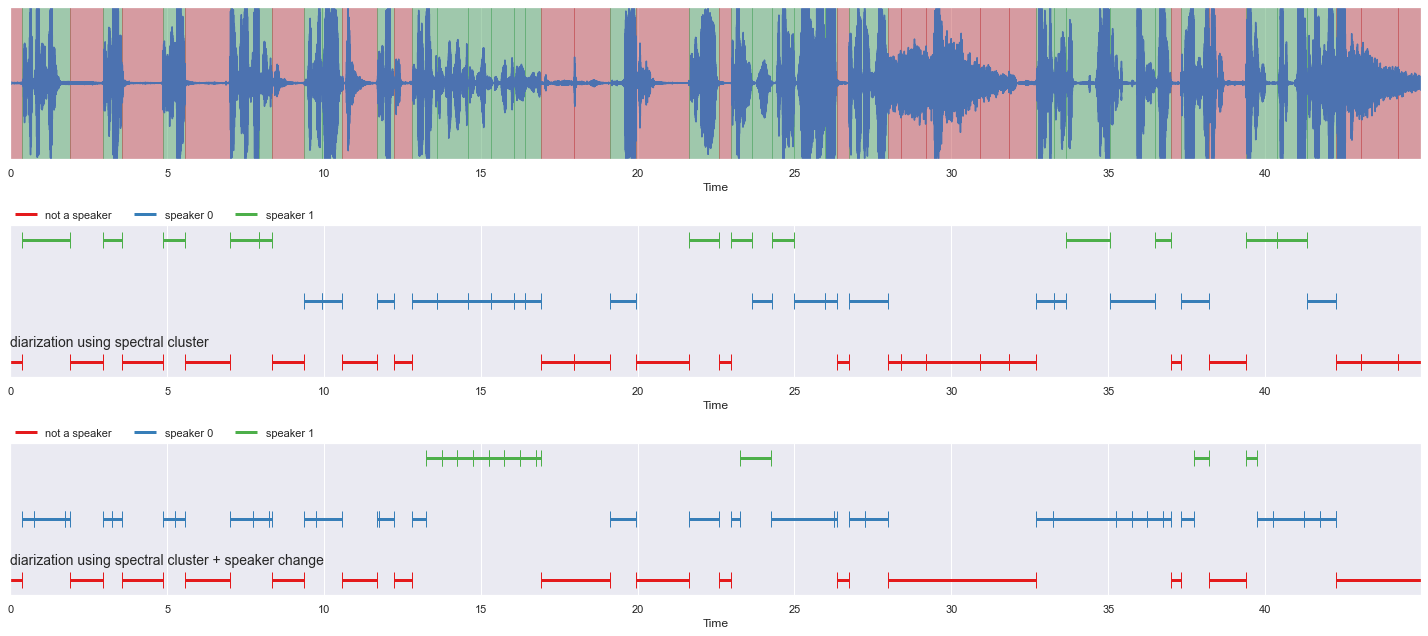

In [49]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_sc_speakernet, 
                                                      'diarization using spectral cluster', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_sc_splitted_speakernet, 
                                                      'diarization using spectral cluster + speaker change', 
                                                      ax = ax[2],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

### How to get timestamp

1. Group multiple frames based on label, this can achieve using `malaya_speech.group.group_frames`.

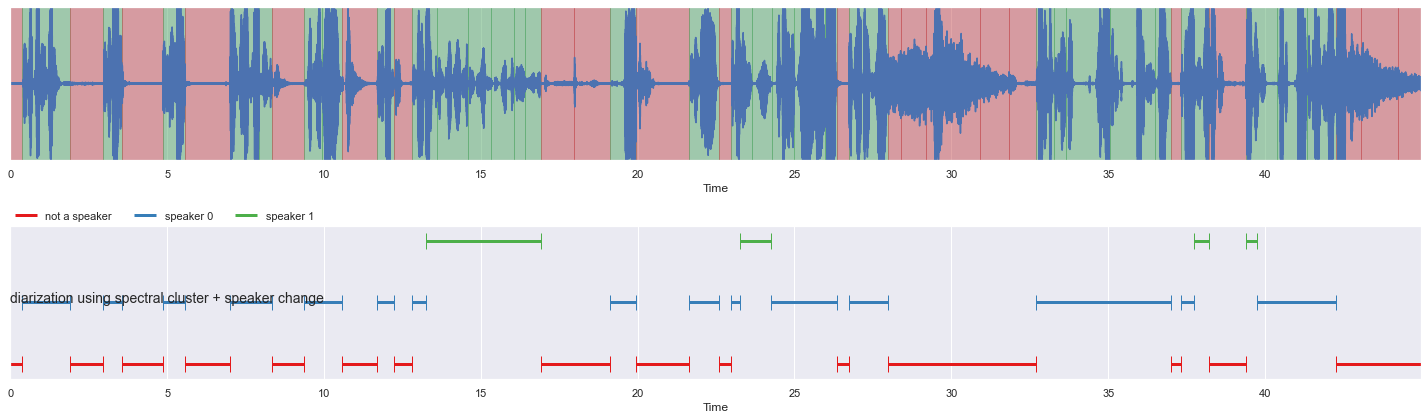

In [50]:
grouped = malaya_speech.group.group_frames(result_diarization_sc_splitted_speakernet)

nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(grouped, 
                                                      'diarization using spectral cluster + speaker change', 
                                                      ax = ax[1],
                                                     x_text = 0.01, y_text = 0.5)
fig.tight_layout()
plt.show()

2. Inspect grouped variable.

In [51]:
grouped[0]

(<malaya_speech.model.frame.Frame at 0x1751beb8148>, 'not a speaker')

`malaya_speech.model.frame.Frame` stores `timestamp` and `duration` attributes.

In [52]:
grouped[0][0].timestamp, grouped[0][0].duration, grouped[0][1]

(0.0, 0.3600000000000001, 'not a speaker')

In [53]:
grouped[1][0].timestamp, grouped[1][0].duration, grouped[1][1]

(0.3600000000000001, 1.5300000000000002, 'speaker 0')

### Reference

1. Neural speech turn segmentation and affinity propagation for speaker diarization, Ruiqing Yin, Herve Bredin, Claude Barras, https://www.isca-speech.org/archive/Interspeech_2018/pdfs/1750.pdf
2. Spectral Clustering, https://github.com/wq2012/SpectralCluster
3. The Singaporean White Boy - The Shan and Rozz Show: EP7, https://www.youtube.com/watch?v=HylaY5e1awo&t=2s&ab_channel=Clicknetwork